# Evaluating Logistic Regression Predictions

/Users/Sari/Documents/Code/Semester 4 workbooks/venv/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


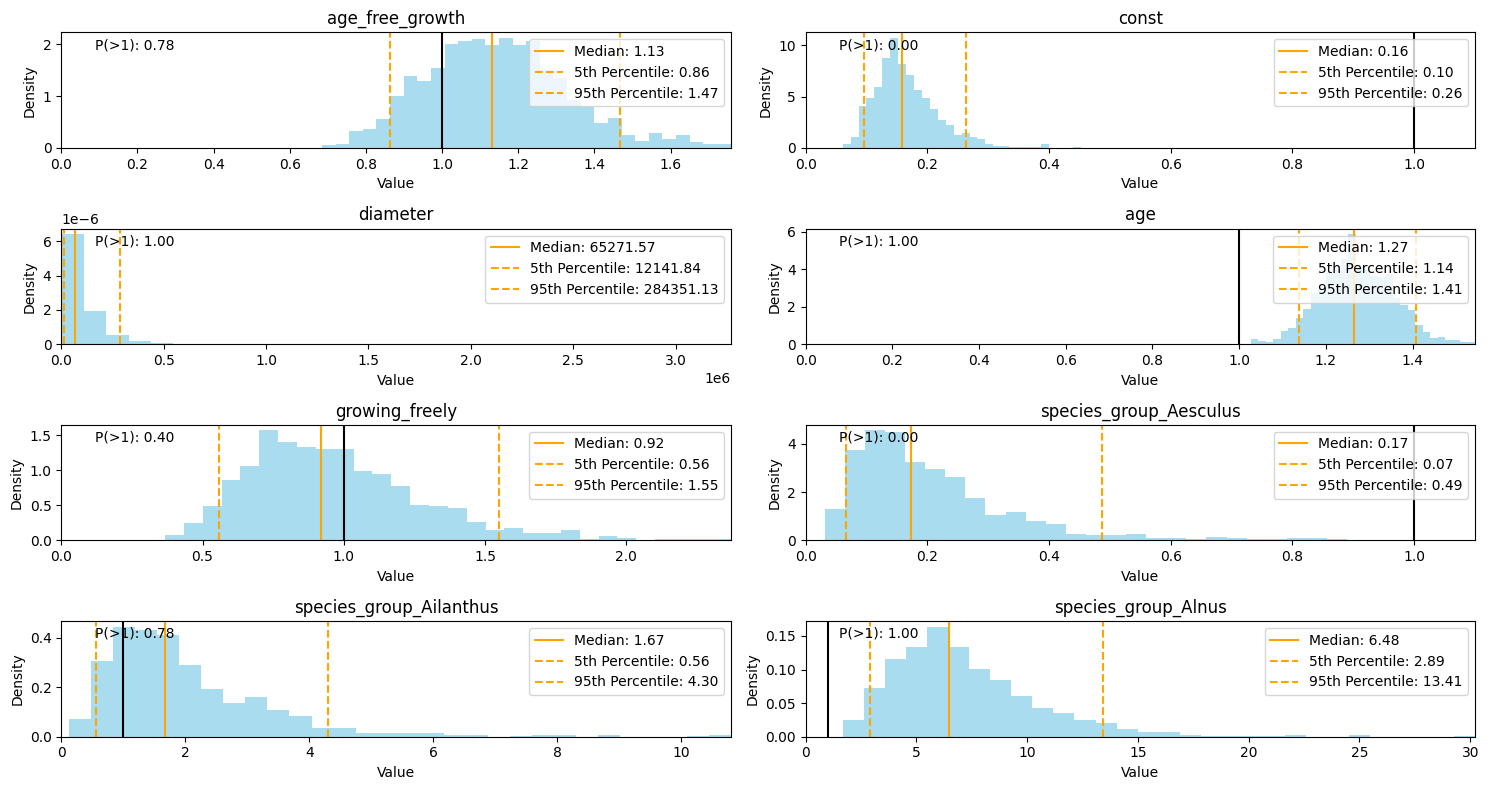

In [ ]:
# Calculate statistics for each coefficient
medians = np.median(simulated_betas_odds, axis=0)
lower_quantiles = np.percentile(simulated_betas_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_betas_odds, 95, axis=0)
prob_positive = np.mean(simulated_betas_odds > 1, axis=0)

# Plot names 
col_names = X_with_intercept.columns

# Plot histograms of each coefficient
coefs_to_plot = 8 # with species dummy variables there are more than 40 coefficients
num_rows = coefs_to_plot // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 8))
axs = axs.flatten()

for i in range(coefs_to_plot):
    ax = axs[i]
    ax.hist(simulated_betas_odds[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(1, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 1
    ax.text(0.05, 0.95, f'P(>1): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{ col_names[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 1 and starts at 0
    ax.set_xlim(left=0, right=max(1.1,abs(simulated_betas_odds[:, i]).max())) 
    
# Hide empty subplot
if simulated_betas.shape[1] % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

In [1]:
import os

# Change the current working directory
os.chdir('/Users/robertocerina/Desktop/CSSci Semester IV/')

In [2]:
# Import Necessary Libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold

# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# and numpy
np.set_printoptions(suppress=True, precision=5)

#### In this workbook we will be attempting to learn a model of  `conspiracy spreading tweets` for the day of Januray 6th in the US. The model's job is topreemptively identify whether the tweet is likely to be fake-news sharing, without delving into the content of the tweet, but rather using a series of general features. 

In [3]:
# Load the labeled dataset of tweets 
df_labs = pd.read_csv('Workshop_V__Evaluating_Model_Performance_for_Categorical_Data/gpt_labels_complete.csv',low_memory=False)

### Part a): Data Cleaning & Exploration

#### Your task is to clean the data. You need to complete the following tasks: 

#### i. drop incomplete records;  

In [4]:
# Drop incomplete records
df_labs = df_labs.dropna().reset_index(drop=True)

#### ii. create a dummy variable, taking value `1` when the conspiracy-assessment is `Yes`, and `0` otherwise;  

#### Hint: use `.astype(int)` to ensure the results are numbers, not booleans. 

In [5]:
# Conspiracy spreading flag
conspiracy_binary = df_labs['Conspiracy Assessment'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)

In [6]:
# What kinds of tweets are we talking about ? 
# Filter rows where 'conspiracy_binary' is 1
conspiracy_texts = df_labs[df_labs['Conspiracy Assessment'] == 'Yes']['text']

# Sample 10 random texts
random_texts = conspiracy_texts.sample(n=10, random_state=np.random.RandomState())

# Iterate through the selected texts and print each one in full
for index, text in enumerate(random_texts, start=1):
    print(f"Text {index}: {text}\n")

Text 1: @SenBillCassidy The Patriots of Louisiana will be watching tomorrow. Stand with President Trump @POTUS and reject fraudulent election results and object to certification.

Text 2: Stephanie Grisham  traitor FLOTUS chief of staff Pence Capitol Treason Lindsey Target confederate #sinclair Mob Lockdown  iheart radio Video Kevin McCarthy Sinclair Newsmax Nazis Fox News Clear Channel Trump Resign Hawley delay Sessions breach https://t.co/9miFOKwiwX

Text 3: Americans know Democrats have nothing good to offer to Americans &amp; stealing is their only option to win election, just like in 2020!It’s unbelievable how Democratic Party going on declined path &amp; now they’re on a free fall! Americans were keeping eyes on Democrats, Trump 2020!🇺🇸 https://t.co/A4o5GaHRoM

Text 4: @jsolomonReports They do not know how to tell the truth. They wouldn’t know it if it hit them in the a$$. Lyin Biden and Harris that tried to a steal an election. Lying treason pedophilia wow and you believe them, 

#### iii. one-hot encode political ideology (retain just conservative and liberal columns), sentiment (retain just negative and positive columns);

In [7]:
# Ideology
pol_lean_one_hot = pd.get_dummies(df_labs, columns=['Political Leanings'])
pol_lean_one_hot = pol_lean_one_hot[['Political Leanings_Conservative','Political Leanings_Liberal']].astype(int)

In [8]:
# Sentiment 
sentiment_one_hot = pd.get_dummies(df_labs, columns=['Sentiment Analysis'])
sentiment_one_hot = sentiment_one_hot[['Sentiment Analysis_Negative','Sentiment Analysis_Positive']].astype(int)

#### iv. Make a binary variable indicating if the source of the tweet was an Apple device;

In [9]:
# Apple product
apple_binary = df_labs['source'].apply(lambda x: 1 if x in ['Tweetbot for Mac',
                                                            'Tweetbot for iΟS',
                                                            'Twitter for Mac',
                                                            'Twitter for iPad',
                                                            'Twitter for iPhone',
                                                            'Twitterrific for iOS'] else 0).rename('apple_binary').astype(int)

In [10]:
# Lexical diversity 
lexical_diversity_likert = df_labs['Lexical Diversity'].astype(int)
# Spelling and Grammar 
spelling_grammar_likert = df_labs['Spelling and Grammar Quality'].astype(int)

In [11]:
# Activity: 
user_active_num = df_labs['statuses_count'].astype(int)
# Popularity: 
user_popular_num = df_labs['followers_count'].astype(int)
# Tweet Popularity
tweet_popular_num = df_labs['retweet_count'].astype(int)

#### v. one-hot encode state identifiers, storing the results in a matrix. 
#### Remember to drop the first dummy (dummy-trap).

In [12]:
# One-hot encode state identifiers
states_one_hot = pd.get_dummies(df_labs, columns=['state_likely_tweeted_from'],drop_first=True)
# Filtering to get just the state dummy columns
state_columns = [col for col in states_one_hot.columns if col.startswith('state_likely_tweeted_from_')]
states_matrix = states_one_hot[state_columns].astype(int)

#### vi. Concatenate the clean variables into a new dataframe called `X`. Exclude the `states_matrix` for now . 
#### Do not include the outcome (conspiracy binary)

In [15]:
# Check correlation matrix (exclude states_matrix for now for visibility)
X = pd.concat([
        pol_lean_one_hot, sentiment_one_hot, 
        apple_binary,
        lexical_diversity_likert,spelling_grammar_likert,
        user_active_num,user_popular_num,tweet_popular_num], axis=1)

#### vii. Calculate the correlation matrix across the outcome and X. 

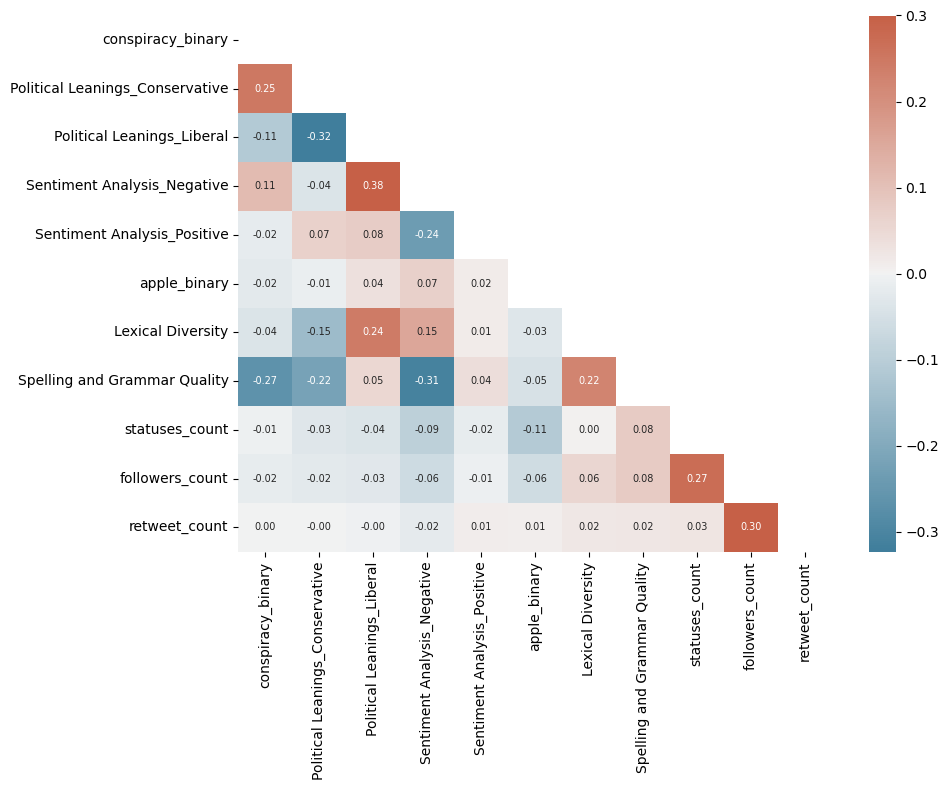

In [16]:
# Add conspiracy_binary as the first column in X to create a combined DataFrame YX
X['conspiracy_binary'] = conspiracy_binary
YX = X[['conspiracy_binary'] + [c for c in X.columns if c != 'conspiracy_binary']]  # Ensure conspiracy_binary is the first column

# Calculate the Correlation Matrix
corr = YX.corr()

# Plotting
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f", annot_kws={"size": 7})
plt.tight_layout()
plt.show()

### Part b): Model Assessment and Selection

#### i. Set up the full design matrix X, this time include the states_matrix, and a constant. 
#### Finally bind the outcome to it and ensure it's the first column of the resulting dataframe. 

In [17]:
# Design matrix
X = pd.concat([
        pol_lean_one_hot, sentiment_one_hot, 
        apple_binary,
        lexical_diversity_likert, spelling_grammar_likert,
        user_active_num, user_popular_num, tweet_popular_num,
        states_matrix
], axis=1)

# Add a constant to the feature matrix for statsmodels
X_const = sm.add_constant(X)

# Get full dataset together 
YX_const =  pd.concat([conspiracy_binary,X_const],axis = 1)

#### ii. Create a validation set (75%) and test set (25%). 
#### Ensure the rows of the full dataset selected for each set are chosen at random. 

In [18]:
# Split data into validation and test (75:25)

# Calculate 25% of the dataset size
num_samples = YX_const.shape[0]* 25 // 100  # Using integer division to get an integer result

# Generate a list of all row IDs
# Assuming row IDs start at 0 and go up to dataset_size-1
row_ids = list(range(YX_const.shape[0]))

# Randomly select 25% of the row IDs
selected_row_ids = random.sample(row_ids, num_samples)

# Subset to create validation and test
YX_const_test = YX_const.iloc[YX_const.index.isin(selected_row_ids)] # the randomly chosen 25% goes to test-set
YX_const_val = YX_const.iloc[~YX_const.index.isin(selected_row_ids)] # the remaining 75% is our validation set

#### iii. Using a dictionary, define three candidate models in terms of the columns of the design matrix involved in each. 
#### The first model should be the homogeneous probability model; the second should have have all covariates except the states; the third should use all the columns. 


In [19]:
# Define predictors for each model variant
predictors = {
    'a': ['const'],
    'b': [col for col in X_const.columns if (col not in states_matrix.columns.to_list())],
    'c': X_const.columns.tolist()
}

#### iv. Pick a metric (or more) on which you want to compare these models. Using cross-validation on the validation set, compare the models and select one you wish to deploy. 

In [20]:
y = YX_const_val['Conspiracy Assessment'] # Target variable

# Define K
K = 5

# Setup the KFold cross-validation
kf = KFold(n_splits=K, shuffle=True)

# Initialize a dictionary to store Brier scores
scores = {key: [] for key in predictors}

# Initialize dictionaries to store scores
brier_scores = {key: [] for key in predictors}
acc_scores = {key: [] for key in predictors}  
balanced_acc_scores = {key: [] for key in predictors}
aic_scores = {key: [] for key in predictors}  # AIC scores

for key, cols in predictors.items():
    
    for train_index, test_index in kf.split(YX_const_val):
        
        # Split into train and test according to the folds 
        X_train, X_test = YX_const_val.iloc[train_index][cols], YX_const_val.iloc[test_index][cols]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # For each fold split, fit the model
        model = sm.Logit(y_train, X_train).fit(disp=0)  # disp=0 suppresses the output
                
        # Predict probabilities
        y_pred_prob = model.predict(X_test)

        # Calculate Brier score
        brier_score = brier_score_loss(y_test, y_pred_prob)
        brier_scores[key].append(brier_score)

        # Convert probabilities to binary predictions (assume simple >0.5 probability as threshold)
        y_pred_binary = (y_pred_prob > 0.5).astype(int)

        # Calculate Accuracy Score
        acc_score = accuracy_score(y_test, y_pred_binary)
        acc_scores[key].append(acc_score)
        
        # Calculate Balanced Accuracy Score
        bal_acc_score = balanced_accuracy_score(y_test, y_pred_binary)
        balanced_acc_scores[key].append(bal_acc_score)
        
        # Store AIC
        aic_scores[key].append(model.aic)
        
        print(model.summary())
        
# Calculate and print the average scores
results = []
for key in predictors.keys():
    average_brier_score = np.mean(brier_scores[key])
    print(average_brier_score)
    average_bal_acc_score = np.mean(balanced_acc_scores[key])
    average_acc_score = np.mean(acc_scores[key])
    average_aic_score = np.mean(aic_scores[key])  # Calculate average AIC
    results.append({
        'Model': key,
        'Average Brier Score': average_brier_score,
        'Average Accuracy': average_acc_score,
        'Average Balanced Accuracy': average_bal_acc_score,
        'Average AIC': average_aic_score
    })

# Convert results to DataFrame for nicer display
results_df = pd.DataFrame(results)
results_df

                             Logit Regression Results                            
Dep. Variable:     Conspiracy Assessment   No. Observations:                21088
Model:                             Logit   Df Residuals:                    21087
Method:                              MLE   Df Model:                            0
Date:                   Sun, 25 Feb 2024   Pseudo R-squ.:               9.758e-11
Time:                           08:54:05   Log-Likelihood:                -4431.9
converged:                          True   LL-Null:                       -4431.9
Covariance Type:               nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8630      0.030    -93.979      0.000      -2.923      -2.803
                             Logit Regression Results                            
Dep. Variable:     Conspi

                             Logit Regression Results                            
Dep. Variable:     Conspiracy Assessment   No. Observations:                21088
Model:                             Logit   Df Residuals:                    21044
Method:                              MLE   Df Model:                           43
Date:                   Sun, 25 Feb 2024   Pseudo R-squ.:                  0.2308
Time:                           08:54:06   Log-Likelihood:                -3355.8
converged:                          True   LL-Null:                       -4362.9
Covariance Type:               nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -1.5402      0.277     -5.554      0.000      -2.084      -0.997
Political Leaning

                             Logit Regression Results                            
Dep. Variable:     Conspiracy Assessment   No. Observations:                21088
Model:                             Logit   Df Residuals:                    21044
Method:                              MLE   Df Model:                           43
Date:                   Sun, 25 Feb 2024   Pseudo R-squ.:                  0.2296
Time:                           08:54:07   Log-Likelihood:                -3365.8
converged:                          True   LL-Null:                       -4368.7
Covariance Type:               nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -1.5482      0.277     -5.596      0.000      -2.090      -1.006
Political Leaning

                             Logit Regression Results                            
Dep. Variable:     Conspiracy Assessment   No. Observations:                21088
Model:                             Logit   Df Residuals:                    21044
Method:                              MLE   Df Model:                           43
Date:                   Sun, 25 Feb 2024   Pseudo R-squ.:                  0.2318
Time:                           08:54:07   Log-Likelihood:                -3417.8
converged:                          True   LL-Null:                       -4449.1
Covariance Type:               nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -1.6818      0.281     -5.976      0.000      -2.233      -1.130
Political Leaning

,Model,Average Brier Score,Average Accuracy,Average Balanced Accuracy,Average AIC
0,a,0.05049,0.94666,0.50000,8784.25942
1,b,0.04326,0.94632,0.55309,6832.23446
2,c,0.04326,0.94670,0.55363,6831.68304


#### v. Re-fit the selected model to the full validation set. 

In [21]:
# Pick model B, in virtue of lower AIC 
# Now fit the model to the full validation set
model = sm.Logit(YX_const_val['Conspiracy Assessment'], YX_const_val[predictors['b']]).fit()

Optimization terminated successfully.
         Current function value: 0.161521
         Iterations 8


In [22]:
# Get summary results
summary = model.summary()
print(summary)

                             Logit Regression Results                            
Dep. Variable:     Conspiracy Assessment   No. Observations:                26360
Model:                             Logit   Df Residuals:                    26349
Method:                              MLE   Df Model:                           10
Date:                   Sun, 25 Feb 2024   Pseudo R-squ.:                  0.2243
Time:                           08:54:07   Log-Likelihood:                -4257.7
converged:                          True   LL-Null:                       -5488.9
Covariance Type:               nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -1.5475      0.187     -8.258      0.000      -1.915      -1.180
Political Leanings_Conservative     1.5720  

### Part c): Model Evaluation and Estimation of Generalisation Error

#### i. Generate 1000 simulations of the regression coefficients by sampling from the empirical posterior distribution. 

In [23]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

#### ii.  For each simulation, generate a predicted probability for the test-set conspiracy assessments. 

In [24]:
# Initialize an array to store predictions from each simulation
predictions = np.zeros((n_simulations, YX_const_test.shape[0]))

# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    log_odds = np.dot(YX_const_test[predictors['b']], beta_simulation)
    probabilities = logistic_sigmoid(log_odds)  # Convert log-odds to probabilities
    predictions[i] = probabilities

In [25]:
predictions

array([[0.01332, 0.03115, 0.131  , ..., 0.03445, 0.01333, 0.01338],
       [0.01649, 0.02754, 0.12409, ..., 0.04932, 0.01748, 0.01656],
       [0.016  , 0.03517, 0.12518, ..., 0.04373, 0.01527, 0.01606],
       ...,
       [0.01573, 0.03463, 0.13773, ..., 0.03923, 0.01526, 0.01577],
       [0.01599, 0.03229, 0.13627, ..., 0.04582, 0.01942, 0.01607],
       [0.0187 , 0.03564, 0.12154, ..., 0.04982, 0.01666, 0.01877]])

#### iii.  For the first 20 assessments in the test-set, plot the posterior distirbution of the probabilities.
#### Highlight whether the density of each lies above or below a given `threshold` for classification. 

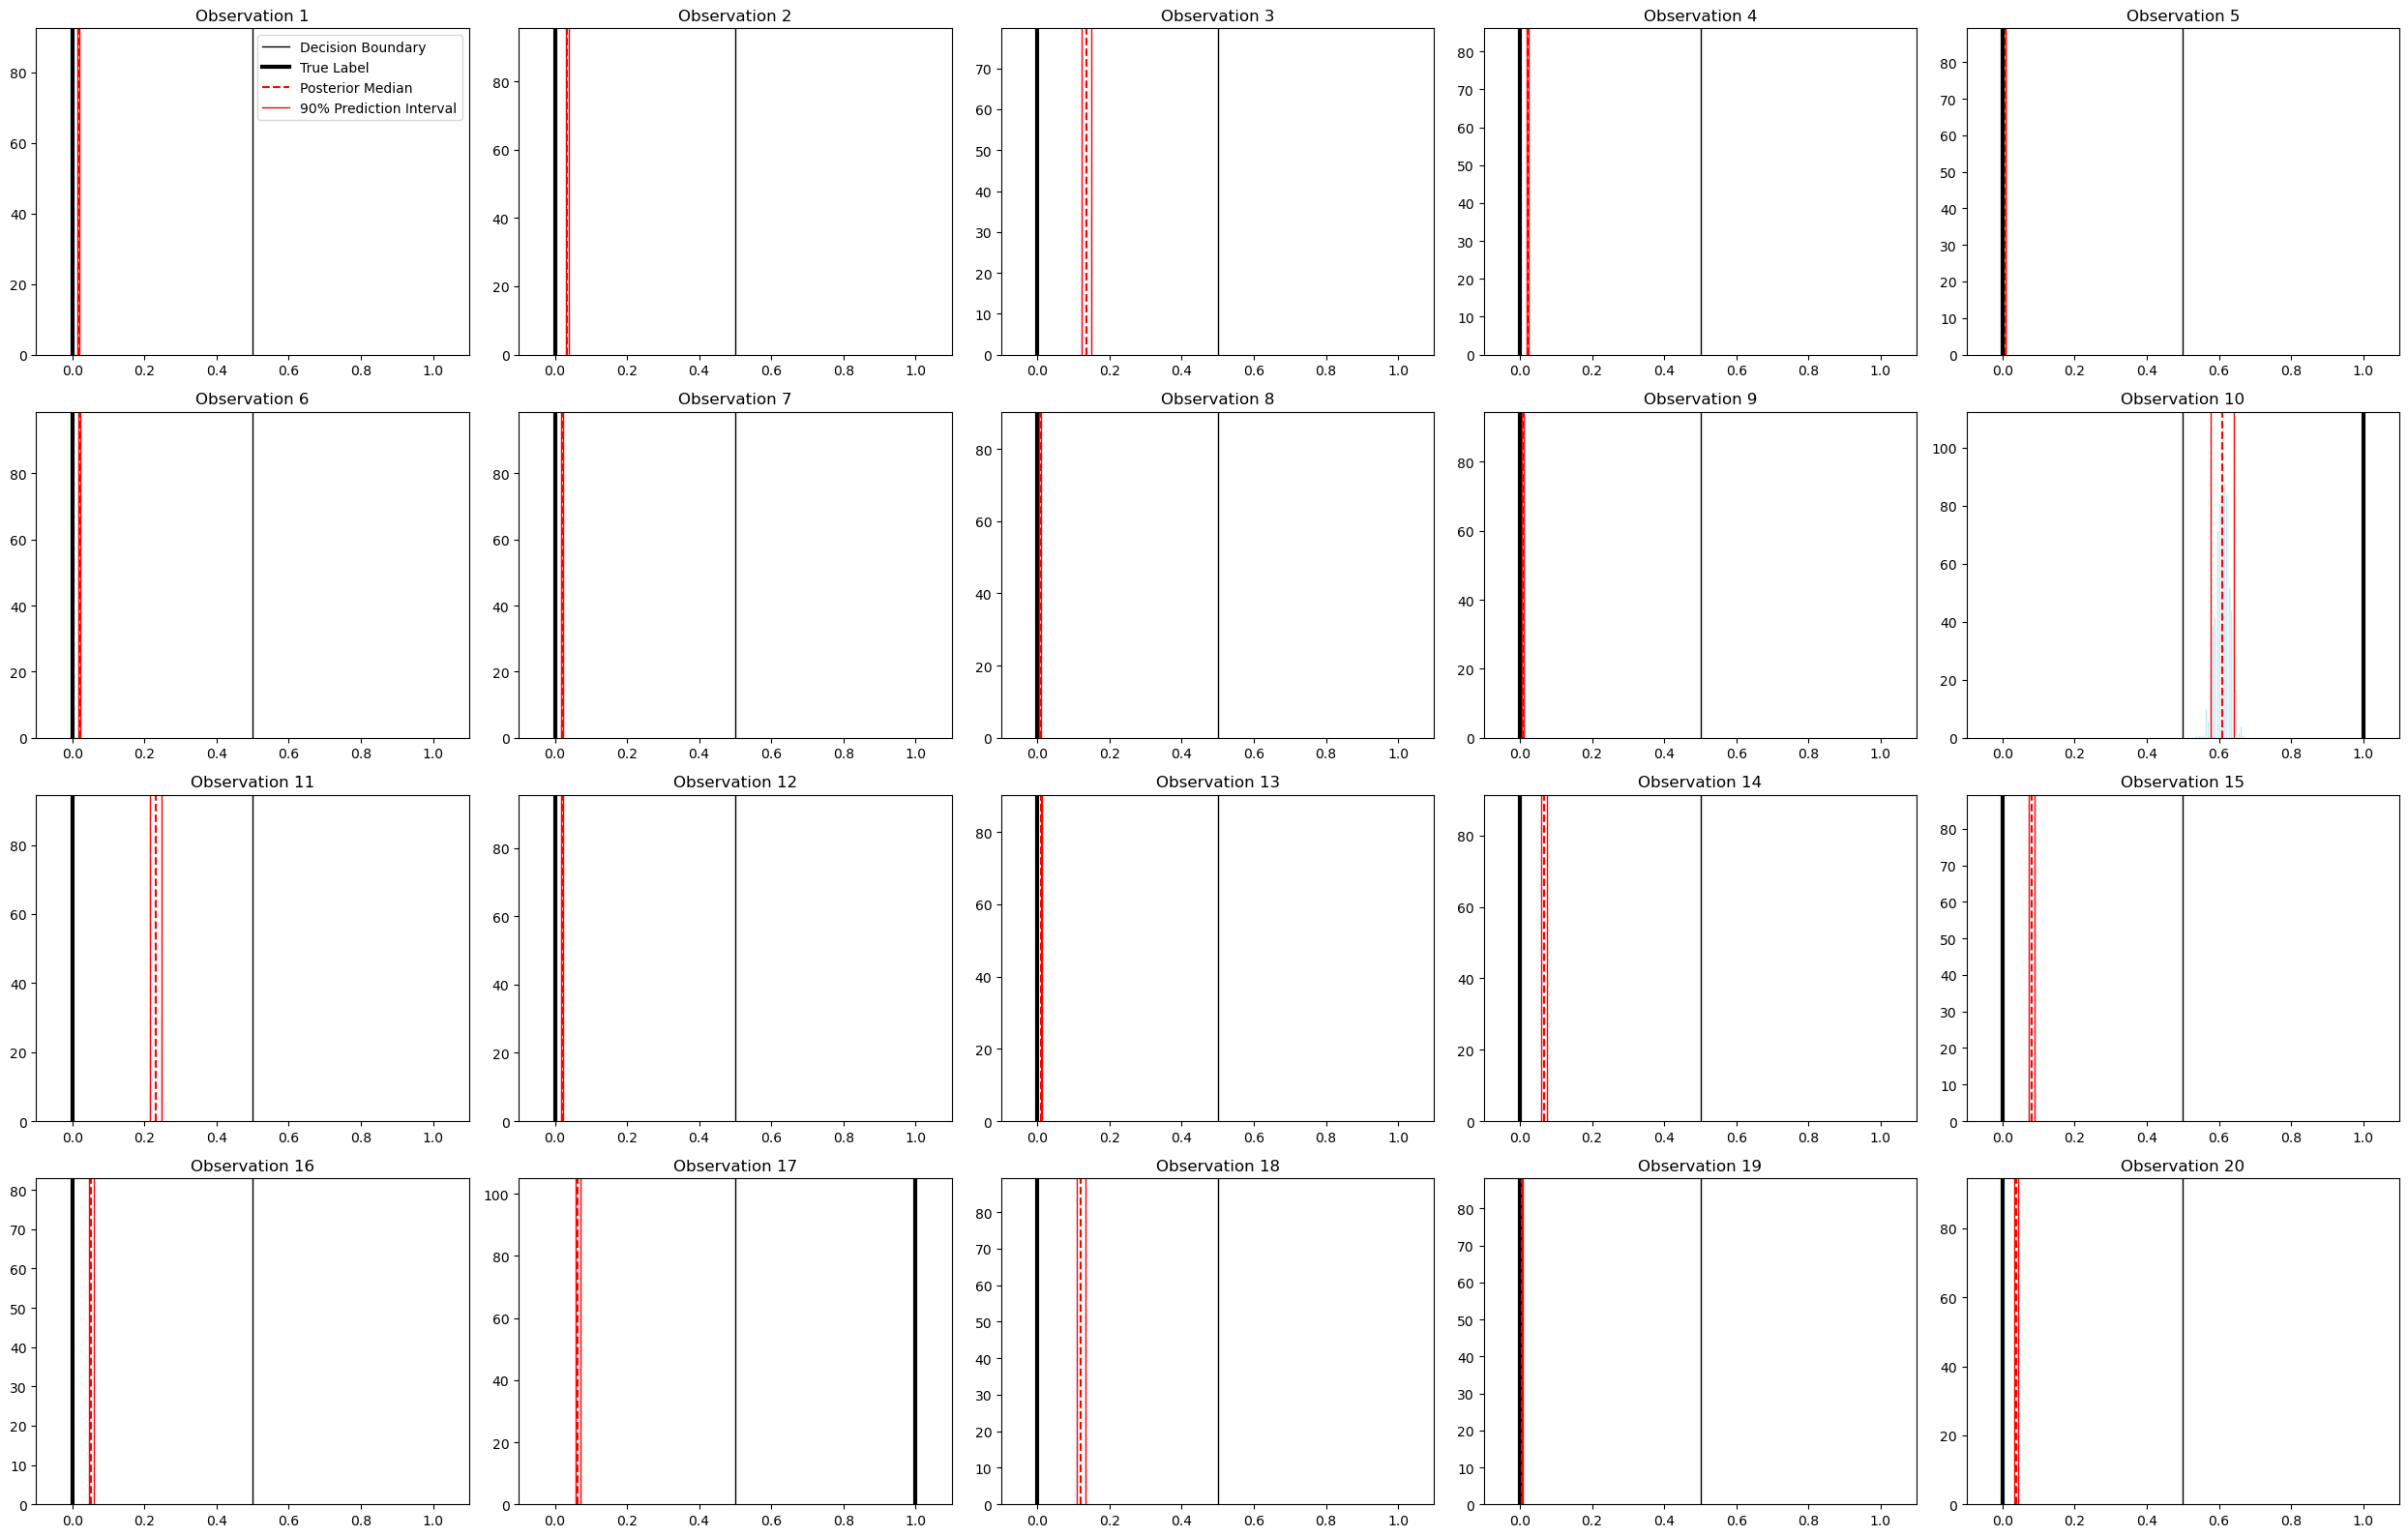

In [26]:
true_labels = YX_const_test['Conspiracy Assessment']

# Calculate posterior median and the 90% prediction interval for each of the first 10 observations
posterior_medians = np.median(predictions, axis=0)
lower_bounds = np.percentile(predictions, 5, axis=0)
upper_bounds = np.percentile(predictions, 95, axis=0)

# Plotting with the adjustments for the 90% prediction interval to be shown with red lines
fig, axes = plt.subplots(4, 5, figsize=(25, 16))

for i in range(20):
    ax = axes[i // 5, i % 5]
    # Histogram of simulated probabilities for observation i
    ax.hist(predictions[:, i], bins=30, color='skyblue', edgecolor='white', alpha=0.7)
    
    # Draw a line for the decision boundary 
    ax.axvline(x=0.5, color='black', linewidth=1, label='Decision Boundary')
    
    # Draw a thick solid black line at the true label position
    true_label_position = 0 if true_labels.iloc[i] == 0 else 1  # Determine the position based on the true label
    ax.axvline(x=true_label_position, color='black', linewidth=3, label='True Label')
    
    # Add posterior median
    ax.axvline(x=posterior_medians[i], color='red', linestyle='--', label='Posterior Median')
    
    # Marking the 90% prediction interval with red lines instead of shading
    ax.axvline(x=lower_bounds[i], color='red', linestyle='-', linewidth=1, label='90% Prediction Interval' if i == 0 else "")
    ax.axvline(x=upper_bounds[i], color='red', linestyle='-', linewidth=1)
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(f'Observation {i+1}')
    if i == 0:  # Add legend to the first subplot only to avoid repetition
        ax.legend()

plt.tight_layout()
plt.show()

#### v. Simulate classes (1s or 0s) for the test-set conspiracy assessments, from the posterior predictive distirbution. 

In [27]:
# Simulate from the posterior-predictive distirbution 
simulated_outcomes = np.random.binomial(1, predictions)

#### vi. Calculate the generalisation error for Classification. 
#### You can choose any classification error metric you wish (i.e. any metric from the confusion matrix). The most basic metric we might be interested about is just `accuracy`. 

#### Hint: We have 1000 simulated predicted classes. For each of those 1000 sets of simulations of the test-set labels, you need to calculate the accuracy. Then you have to plot the histogram of the accuracies. 

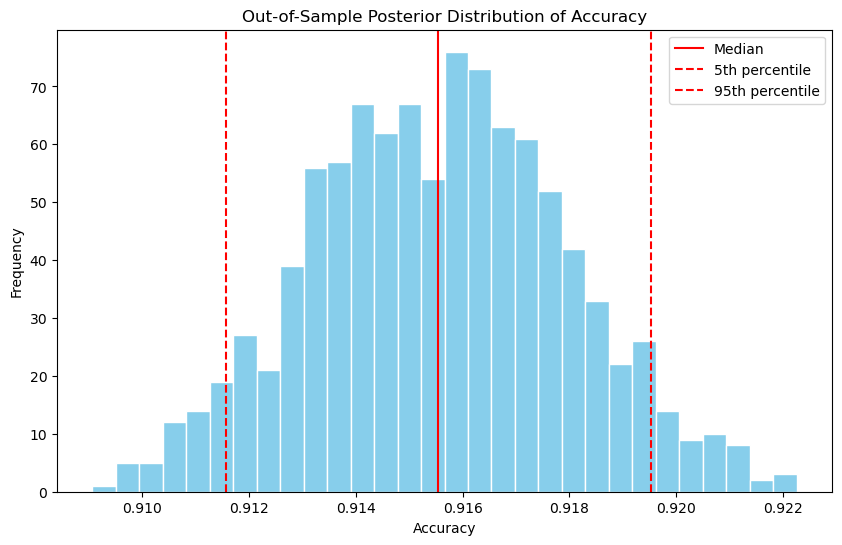

In [28]:
# Calculate accuracy for each simulation
accuracies = []
for i in range(n_simulations):
    accuracies.append(accuracy_score(true_labels, simulated_outcomes[i]))

# Plot the histogram of accuracies
plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=30, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(accuracies), color='red', label='Median')
plt.axvline(x=np.percentile(accuracies, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(accuracies, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Accuracy')
plt.legend()
plt.show()

In [29]:
#### Here is an example with the `Generalisation ROC Curve` and corresponding AUC. 

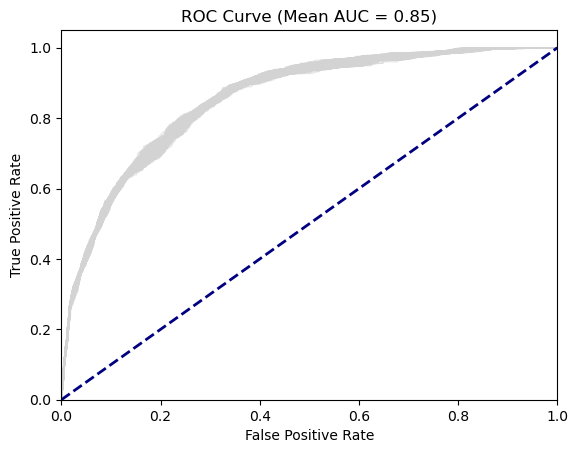

In [30]:
# Initialize lists to store TPRs (True Positive Rate), FPRs (False Positive Rare), and AUCs (Area Under the Curve) for each simulation
tprs = []
fprs = []
aucs = []

# Calculate ROC curve and AUC for each simulation
for i in range(n_simulations):
    fpr, tpr, thresholds = roc_curve(true_labels, predictions[i])
    roc_auc = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, color='lightgray', lw=1, alpha=0.5)  # Plot each ROC curve faintly

# Calculate the mean AUC
mean_auc = np.mean(aucs)

# Plotting
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Mean AUC = {mean_auc:.2f})')
plt.show()

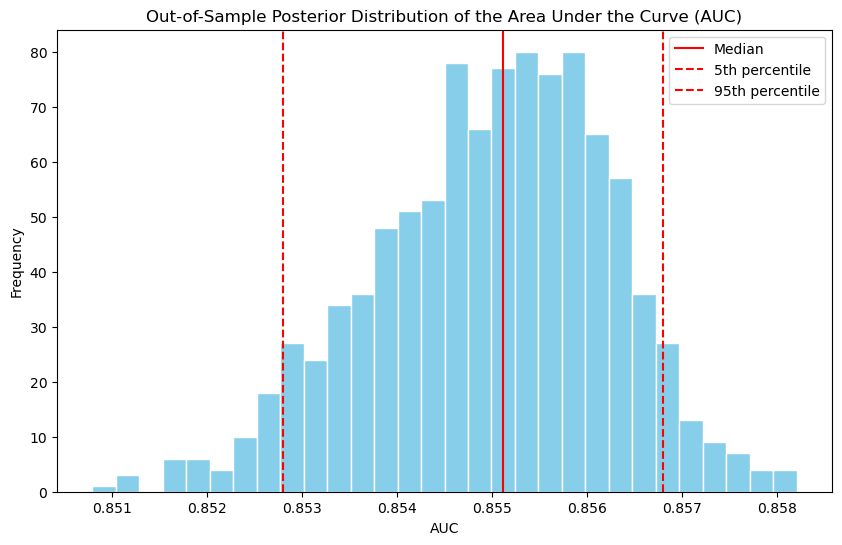

In [31]:
# Plot the histogram of AUC
plt.figure(figsize=(10, 6))
plt.hist(aucs, bins=30, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(aucs), color='red', label='Median')
plt.axvline(x=np.percentile(aucs, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(aucs, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of the Area Under the Curve (AUC)')
plt.legend()
plt.show()

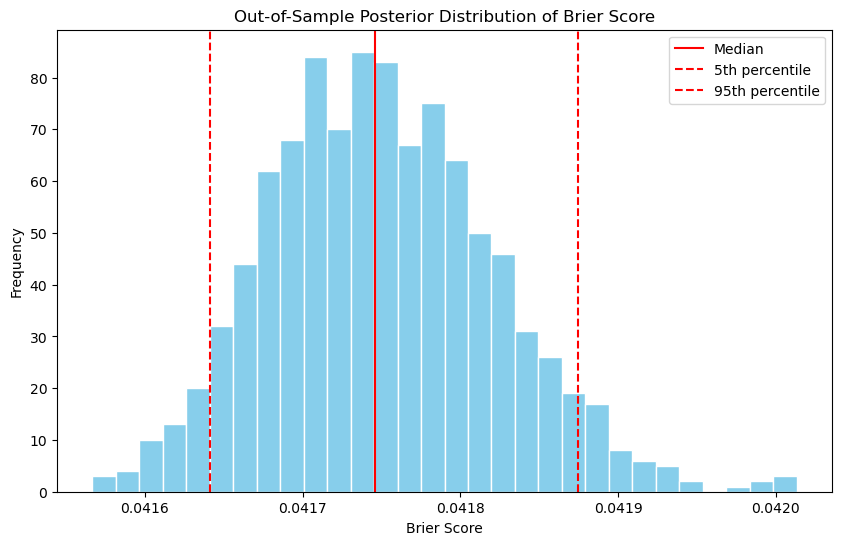

In [32]:
# Calculate Brier score for each simulation
briers = [brier_score_loss(true_labels, predictions[i]) for i in range(n_simulations)]

# Plot the histogram of Brier scores
plt.figure(figsize=(10, 6))
plt.hist(briers, bins=30, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(briers), color='red', label='Median')
plt.axvline(x=np.percentile(briers, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(briers, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Brier Score')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Brier Score')
plt.legend()
plt.show()
